<a href="https://colab.research.google.com/github/miltiadiss/CEID_NE577-5G-Architectures-Technologies-Applications-and-Key-Performance-Indexes/blob/main/Code/LSTM_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **LSTM**

## **Feature engineering & fine tuning**

We first apply Feature Engineering to add rolling window statistic features and time based features on both training and test sets as input features to boost the performance of the model. Additionally, we apply log tranform on the bitrate features to handle the huge scale differences with the other features.

In [4]:
# Load train and test datasets
train_df = pd.read_csv("/content/drive/MyDrive/training_set.csv")
test_df = pd.read_csv("/content/drive/MyDrive/test_set.csv")

apply_log_to = ['DL_bitrate', 'UL_bitrate'] # Features for log transformation

for df in [train_df, test_df]:
    # Apply log1p transformation to selected features
    for col in apply_log_to:
        df[col] = np.log1p(df[col])

In [5]:
train_df

,Timestamp,Speed,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,NRxRSRP,NRxRSRQ,ServingCell_Distance,Categorical_Impact
0,2017-11-21 15:03:50,0.0,-95.0,-13.0,4.0,10.0,-80.0,0.000000,0.000000,-106.0,-19.0,551.370000,0.758840
1,2017-11-21 15:03:51,0.0,-95.0,-13.0,2.0,8.0,-78.0,0.000000,0.000000,-106.0,-19.0,551.370000,0.599827
2,2017-11-21 15:03:52,0.0,-95.0,-13.0,13.0,9.0,-80.0,0.000000,0.000000,-106.0,-19.0,553.430000,0.599827
3,2017-11-21 15:03:53,1.0,-95.0,-13.0,13.0,9.0,-80.0,0.000000,0.000000,-106.0,-19.0,563.480000,0.599827
4,2017-11-21 15:03:54,1.0,-97.0,-13.0,-2.0,9.0,-80.0,0.000000,0.000000,-106.0,-19.0,563.480000,0.599827
...,...,...,...,...,...,...,...,...,...,...,...,...,...
138948,2018-01-18 15:03:26,0.0,-95.0,-14.0,-5.0,8.0,-88.0,8.826441,4.644391,-98.0,-19.0,2911.320000,0.581546
138949,2018-01-18 15:03:26,46.0,-104.0,-15.0,-2.0,7.0,-88.0,9.570669,5.379897,-107.0,-16.0,4965.960421,0.784428
138950,2018-01-18 15:03:27,0.0,-95.0,-14.0,-5.0,8.0,-88.0,9.041211,4.962845,-98.0,-19.0,2911.320000,0.581546
138951,2018-01-18 15:03:28,46.0,-104.0,-15.0,-2.0,7.0,-88.0,9.640758,5.549076,-107.0,-16.0,4965.960421,0.784428


Then, we prepare the input features and the target (X, y) for the model by creating the optimal amount of windows for the timeseries. We split the training set into the following subsets:

- Training Set: 60% (75% of initial training set)

- Validation Set: 20% (25% of initial training set)

The test set remains 20% as previously.

We also apply Min-Max Normalization since the numeric features are measured in different units and calculate the performance of the model for different window sizes in order to keep the one that corresponds to the lowest error metric value.


Training LSTM with time_steps = 32
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
 Validation MAE: 0.0801

Training LSTM with time_steps = 64
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
 Validation MAE: 0.0803

Training LSTM with time_steps = 96
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
 Validation MAE: 0.0819


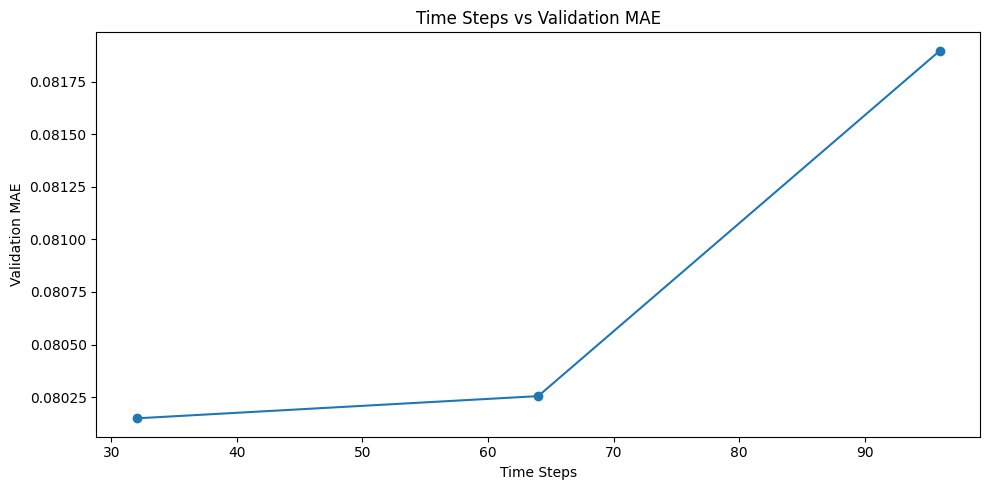

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# === Δημιουργία time-series windows ===
def create_dataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# === Προετοιμασία χαρακτηριστικών και στόχου ===
target_col = "DL_bitrate"

X_full = train_df.drop(columns=["Timestamp", target_col, "Predicted_DL_bitrate"], errors="ignore")
y_full = train_df[target_col]

X_test_raw = test_df.drop(columns=["Timestamp", target_col, "Predicted_DL_bitrate"], errors="ignore")
y_test_raw = test_df[target_col]

# === Split σε 60% train, 20% val, 20% test ===
n = len(X_full)
n_train = int(n * 0.75)

X_train_raw = X_full.iloc[:n_train]
y_train_raw = y_full.iloc[:n_train]
X_val_raw = X_full.iloc[n_train:]
y_val_raw = y_full.iloc[n_train:]

# === Κανονικοποίηση ===
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = pd.DataFrame(scaler_X.fit_transform(X_train_raw), columns=X_train_raw.columns)
X_val_scaled = pd.DataFrame(scaler_X.transform(X_val_raw), columns=X_val_raw.columns)
X_test_scaled = pd.DataFrame(scaler_X.transform(X_test_raw), columns=X_test_raw.columns)

y_train_scaled = pd.Series(scaler_y.fit_transform(y_train_raw.values.reshape(-1, 1)).flatten())
y_val_scaled = pd.Series(scaler_y.transform(y_val_raw.values.reshape(-1, 1)).flatten())
y_test_scaled = pd.Series(scaler_y.transform(y_test_raw.values.reshape(-1, 1)).flatten())

# === Time steps προς δοκιμή ===
time_steps_list = [32, 64, 96]
val_mae_list = []

best_mae = float('inf')
best_model_info = {}

for ts in time_steps_list:
    print(f"\nTraining LSTM with time_steps = {ts}")

    # Time-series windows
    X_seq_train, y_seq_train = create_dataset(X_train_scaled, y_train_scaled, ts)
    X_seq_val, y_seq_val = create_dataset(X_val_scaled, y_val_scaled, ts)

    # LSTM μοντέλο
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(ts, X_seq_train.shape[2])))
    model.add(LSTM(64))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_seq_train, y_seq_train,
        validation_data=(X_seq_val, y_seq_val),
        epochs=50,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )

    # Υπολογισμός MAE σε αρχικό scale (expm1 αντιστροφή log1p)
    y_val_pred = model.predict(X_seq_val)
    y_val_true = scaler_y.inverse_transform(y_seq_val.reshape(-1, 1))
    y_val_pred_true = scaler_y.inverse_transform(y_val_pred)
    val_mae = mean_absolute_error(np.expm1(y_val_true), np.expm1(y_val_pred_true))
    val_mae_list.append(val_mae)

    print(f" Validation MAE: {val_mae:.4f}")

    if val_mae < best_mae:
        best_mae = val_mae
        best_model_info = {
            "model": model,
            "time_steps": ts,
            "X_train": X_seq_train,
            "y_train": y_seq_train,
            "X_val": X_seq_val,
            "y_val": y_seq_val,
            "history": history
        }

# === Γράφημα: Time Steps vs Validation MAE ===
plt.figure(figsize=(10, 5))
plt.plot(time_steps_list, val_mae_list, marker='o')
plt.title("Time Steps vs Validation MAE")
plt.xlabel("Time Steps")
plt.ylabel("Validation MAE")
plt.tight_layout()
plt.show()

## **Model training**

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 11)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 32, 128)        │        71,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (AttentionLayer)      │ (None, 64)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,249 (473.63 KB)

 Trainable params: 121,249 (473.63 KB)

 Non-trainable params: 0 (0.00 B)

3256/3256 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


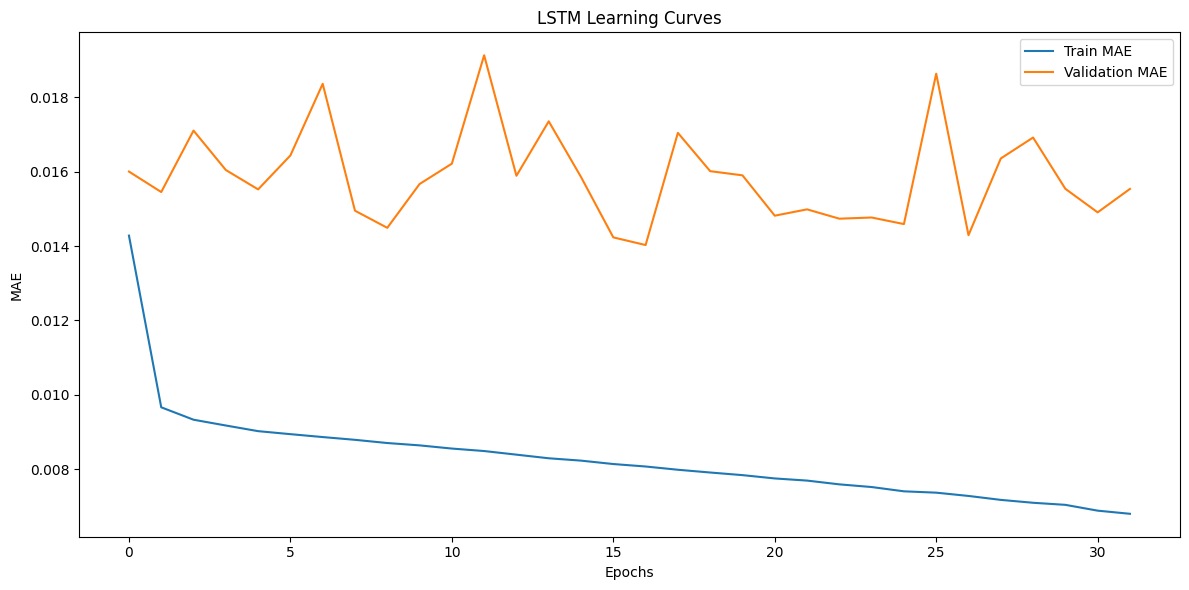

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Input
from keras.callbacks import EarlyStopping
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import Layer
import tensorflow as tf
from keras.models import Model

# Define model inputs and target (X,y)
X_full = train_df.drop(columns=["Timestamp", "DL_bitrate", "Predicted_DL_bitrate"], errors="ignore")
y_full_raw = train_df["DL_bitrate"]

# Split into 60-20-20 ratio for train, validation, test
n = len(X_full)
n_train = int(n * 0.75)

X_train_raw = X_full.iloc[:n_train] # 75% of 80% to get 60% for training set
y_train_raw = y_full_raw.iloc[:n_train]
X_val_raw = X_full.iloc[n_train:] # 25% of 80% to get 20% for validation set
y_val_raw = y_full_raw.iloc[n_train:]

# Test set is the rest 20%
X_test_raw = test_df.drop(columns=["Timestamp", "DL_bitrate", "Predicted_DL_bitrate"], errors="ignore")
y_test_raw = test_df["DL_bitrate"]

# Apply MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(X_train_raw)
X_val = scaler_X.transform(X_val_raw)
X_test = scaler_X.transform(X_test_raw)

y_train = scaler_y.fit_transform(y_train_raw.values.reshape(-1, 1)).flatten()
y_val = scaler_y.transform(y_val_raw.values.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test_raw.values.reshape(-1, 1)).flatten()  # Only transform without fit on the other 2 subsets

# === Χρήση της καλύτερης παραμέτρου time_steps ===
best_ts = 32

# === Δημιουργία παραθύρων για κάθε σύνολο ===
X_seq_train = []
y_seq_train = []
X_seq_val = []
y_seq_val = []
X_seq_test = []
y_seq_test = []

# Δημιουργία time-series windows
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# === Custom Attention Layer ===
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1),
                                 initializer="normal",
                                 trainable=True)
        self.b = self.add_weight(shape=(input_shape[1], 1),
                                 initializer="zeros",
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(inputs, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = tf.keras.backend.sum(inputs * a, axis=1)
        self.attention_weights = a
        return output

X_train_scaled = pd.DataFrame(scaler_X.fit_transform(X_train_raw), columns=X_train_raw.columns, index=X_train_raw.index)
X_val_scaled = pd.DataFrame(scaler_X.transform(X_val_raw), columns=X_val_raw.columns, index=X_val_raw.index)
X_test_scaled = pd.DataFrame(scaler_X.transform(X_test_raw), columns=X_test_raw.columns, index=X_test_raw.index)

y_train_scaled = pd.Series(scaler_y.fit_transform(y_train_raw.values.reshape(-1, 1)).flatten(), index=y_train_raw.index)
y_val_scaled = pd.Series(scaler_y.transform(y_val_raw.values.reshape(-1, 1)).flatten(), index=y_val_raw.index)
y_test_scaled = pd.Series(scaler_y.transform(y_test_raw.values.reshape(-1, 1)).flatten(), index=y_test_raw.index)

X_seq_train, y_seq_train = create_dataset(X_train_scaled, y_train_scaled, best_ts)
X_seq_val, y_seq_val = create_dataset(X_val_scaled, y_val_scaled, best_ts)
X_seq_test, y_seq_test = create_dataset(X_test_scaled, y_test_scaled, best_ts)

# === Εκπαίδευση LSTM με τις καλύτερες παραμέτρους ===
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, LayerNormalization

# === LSTM + Attention ===
input_layer = Input(shape=(best_ts, X_seq_train.shape[2]))

x = LSTM(128, return_sequences=True)(input_layer)
x = LSTM(64, return_sequences=True)(x)

x = AttentionLayer(name="attention")(x)

output = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='mse')
model.summary()

# === Train ===
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = model.fit(
    X_seq_train, y_seq_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_seq_val, y_seq_val),
    callbacks=[early_stop],
    verbose=0
)

# === Προβλέψεις
y_train_pred = model.predict(X_seq_train)
y_val_pred = model.predict(X_seq_val)
y_test_pred = model.predict(X_seq_test)

# === Αντιστροφή log1p + MinMax
y_train_true = np.expm1(scaler_y.inverse_transform(y_seq_train.reshape(-1, 1)).flatten())
y_val_true = np.expm1(scaler_y.inverse_transform(y_seq_val.reshape(-1, 1)).flatten())
y_test_true = np.expm1(scaler_y.inverse_transform(y_seq_test.reshape(-1, 1)).flatten())

y_train_pred_denorm = np.expm1(scaler_y.inverse_transform(y_train_pred.reshape(-1, 1)).flatten())
y_val_pred_denorm = np.expm1(scaler_y.inverse_transform(y_val_pred.reshape(-1, 1)).flatten())
y_test_pred_denorm = np.expm1(scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).flatten())

# === Learning Curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label="Train MAE")
plt.plot(history.history['val_loss'], label="Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("LSTM Learning Curves")
plt.legend()
plt.tight_layout()
plt.show()

# === Δημιουργία predictions_df
predictions_df = pd.concat([
    pd.DataFrame({"true": y_train_true, "pred": y_train_pred_denorm, "set": "train"}),
    pd.DataFrame({"true": y_val_true, "pred": y_val_pred_denorm, "set": "val"}),
    pd.DataFrame({"true": y_test_true, "pred": y_test_pred_denorm, "set": "test"})
], ignore_index=True)

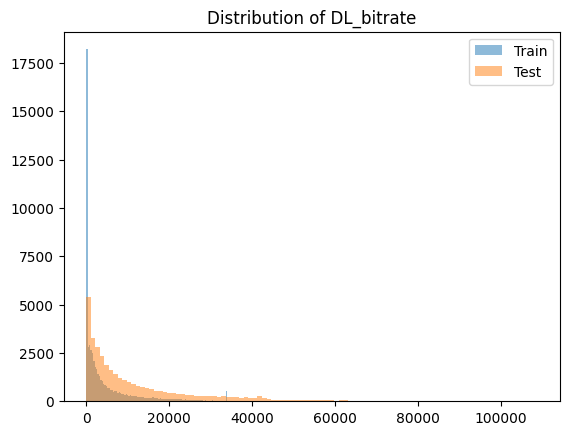

In [ ]:
plt.hist(np.expm1(y_train_raw), bins=100, alpha=0.5, label="Train")
plt.hist(np.expm1(y_test_raw), bins=100, alpha=0.5, label="Test")
plt.legend()
plt.title("Distribution of DL_bitrate")
plt.show()

In [ ]:
high_threshold = train_df["DL_bitrate"].quantile(0.90)
high_bitrate_df = train_df[train_df["DL_bitrate"] > high_threshold]
# Επαναληπτικό oversampling (π.χ. 3 φορές)
oversampled_df = pd.concat([train_df, high_bitrate_df]*3, ignore_index=True)

# Εναλλακτικά: bootstrap (με επαναληπτική δειγματοληψία)
high_bitrate_bootstrap = high_bitrate_df.sample(n=len(high_bitrate_df)*3, replace=True, random_state=42)
oversampled_df = pd.concat([train_df, high_bitrate_bootstrap], ignore_index=True)
# Shuffle τα δεδομένα
new_train_df = oversampled_df.sample(frac=1.0, random_state=42).reset_index(drop=True)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define model inputs and target (X,y)
X_full = new_train_df.drop(columns=["Timestamp", "DL_bitrate", "Predicted_DL_bitrate"], errors="ignore")
y_full_raw = new_train_df["DL_bitrate"]

# Split into 60-20-20 ratio for train, validation, test
n = len(X_full)
n_train = int(n * 0.75)

X_train_raw = X_full.iloc[:n_train] # 75% of 80% to get 60% for training set
y_train_raw = y_full_raw.iloc[:n_train]
X_val_raw = X_full.iloc[n_train:] # 25% of 80% to get 20% for validation set
y_val_raw = y_full_raw.iloc[n_train:]

# Test set is the rest 20%
X_test_raw = test_df.drop(columns=["Timestamp", "DL_bitrate", "Predicted_DL_bitrate"], errors="ignore")
y_test_raw = test_df["DL_bitrate"]

# Apply MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(X_train_raw)
X_val = scaler_X.transform(X_val_raw)
X_test = scaler_X.transform(X_test_raw)

y_train = scaler_y.fit_transform(y_train_raw.values.reshape(-1, 1)).flatten()
y_val = scaler_y.transform(y_val_raw.values.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test_raw.values.reshape(-1, 1)).flatten()  # Only transform without fit on the other 2 subsets

# === Χρήση της καλύτερης παραμέτρου time_steps ===
best_ts = 32

# === Δημιουργία παραθύρων για κάθε σύνολο ===
X_seq_train = []
y_seq_train = []
X_seq_val = []
y_seq_val = []
X_seq_test = []
y_seq_test = []

# Δημιουργία time-series windows
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train_scaled = pd.DataFrame(scaler_X.fit_transform(X_train_raw), columns=X_train_raw.columns, index=X_train_raw.index)
X_val_scaled = pd.DataFrame(scaler_X.transform(X_val_raw), columns=X_val_raw.columns, index=X_val_raw.index)
X_test_scaled = pd.DataFrame(scaler_X.transform(X_test_raw), columns=X_test_raw.columns, index=X_test_raw.index)

y_train_scaled = pd.Series(scaler_y.fit_transform(y_train_raw.values.reshape(-1, 1)).flatten(), index=y_train_raw.index)
y_val_scaled = pd.Series(scaler_y.transform(y_val_raw.values.reshape(-1, 1)).flatten(), index=y_val_raw.index)
y_test_scaled = pd.Series(scaler_y.transform(y_test_raw.values.reshape(-1, 1)).flatten(), index=y_test_raw.index)

X_seq_train, y_seq_train = create_dataset(X_train_scaled, y_train_scaled, best_ts)
X_seq_val, y_seq_val = create_dataset(X_val_scaled, y_val_scaled, best_ts)
X_seq_test, y_seq_test = create_dataset(X_test_scaled, y_test_scaled, best_ts)

# === Εκπαίδευση LSTM με τις καλύτερες παραμέτρους ===
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, LayerNormalization

model = Sequential()
# Bidirectional LSTM για πιο πλήρη κατανόηση της ακολουθίας
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(best_ts, X_seq_train.shape[2])))
model.add(LayerNormalization())
model.add(Dropout(0.3))

# Δεύτερο LSTM layer
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.3))

# Fully connected layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))  # Τελική έξοδος για regression

model.compile(optimizer='adam', loss='mse')
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = model.fit(
    X_seq_train, y_seq_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_seq_val, y_seq_val),
    callbacks=[early_stop],
    verbose=0
)

# === Προβλέψεις
y_train_pred = model.predict(X_seq_train)
y_val_pred = model.predict(X_seq_val)
y_test_pred = model.predict(X_seq_test)

# === Αντιστροφή log1p + MinMax
y_train_true = np.expm1(scaler_y.inverse_transform(y_seq_train.reshape(-1, 1)).flatten())
y_val_true = np.expm1(scaler_y.inverse_transform(y_seq_val.reshape(-1, 1)).flatten())
y_test_true = np.expm1(scaler_y.inverse_transform(y_seq_test.reshape(-1, 1)).flatten())

y_train_pred_denorm = np.expm1(scaler_y.inverse_transform(y_train_pred.reshape(-1, 1)).flatten())
y_val_pred_denorm = np.expm1(scaler_y.inverse_transform(y_val_pred.reshape(-1, 1)).flatten())
y_test_pred_denorm = np.expm1(scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).flatten())

# === Learning Curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label="Train MAE")
plt.plot(history.history['val_loss'], label="Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("LSTM Learning Curves")
plt.legend()
plt.tight_layout()
plt.show()

# === Δημιουργία predictions_df
predictions_df = pd.concat([
    pd.DataFrame({"true": y_train_true, "pred": y_train_pred_denorm, "set": "train"}),
    pd.DataFrame({"true": y_val_true, "pred": y_val_pred_denorm, "set": "val"}),
    pd.DataFrame({"true": y_test_true, "pred": y_test_pred_denorm, "set": "test"})
], ignore_index=True)

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional)      │ (None, 32, 256)             │         160,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_2                │ (None, 32, 256)             │             512 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 32, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 333,953 (1.27 MB)

 Trainable params: 333,953 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

## **Model evaluation**

In [10]:
# Print the final error metrics values for all the subsets
print("-" * 40)
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train_true, y_train_pred_denorm)):.2f}")
print(f"Train MAE : {mean_absolute_error(y_train_true, y_train_pred_denorm):.2f}")
print("-" * 40)
print(f"Validation RMSE: {np.sqrt(mean_squared_error(y_val_true, y_val_pred_denorm)):.2f}")
print(f"Validation MAE : {mean_absolute_error(y_val_true, y_val_pred_denorm):.2f}")
print("-" * 40)
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test_true, y_test_pred_denorm)):.2f}")
print(f"Test MAE : {mean_absolute_error(y_test_true, y_test_pred_denorm):.2f}")

# Calculate the mean true value of the test set by inverting the log transform and the normalization
test_data = predictions_df[predictions_df["set"] == "test"]
mean_dl_bitrate_actual_value = test_data["true"].mean()

# Print mean value and percentage of MAE, RMSE for DL_bitrate
test_mae = mean_absolute_error(test_data["true"], test_data["pred"])
test_rmse = root_mean_squared_error(test_data["true"], test_data["pred"])
print(f"\nMean actual DL_bitrate in test set: {mean_dl_bitrate_actual_value:.2f} Kbps")
print(f"Relative MAE: {(test_mae / mean_dl_bitrate_actual_value) * 100:.2f}%")
print(f"Relative RMSE: {(test_rmse / mean_dl_bitrate_actual_value) * 100:.2f}%")

----------------------------------------
Train RMSE: 3641.85
Train MAE : 2021.05
----------------------------------------
Validation RMSE: 9923.34
Validation MAE : 6938.82
----------------------------------------
Test RMSE: 13677.52
Test MAE : 7902.97

Mean actual DL_bitrate in test set: 12238.84 Kbps
Relative MAE: 64.57%
Relative RMSE: 111.76%


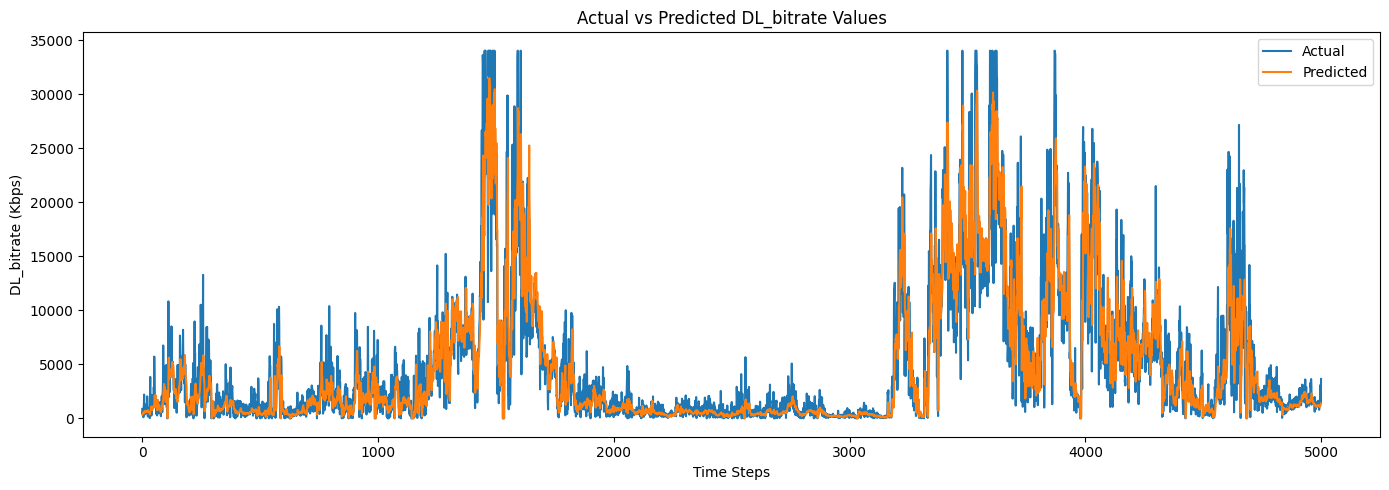

In [11]:
# Plot Timeseries Actual vs Predicted (Test Set)
plt.figure(figsize=(14, 5))
plt.plot(predictions_df["true"].values[:5000], label='Actual')
plt.plot(predictions_df["pred"].values[:5000], label='Predicted')
plt.title("Actual vs Predicted DL_bitrate Values")
plt.xlabel("Time Steps")
plt.ylabel("DL_bitrate (Kbps)")
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
predictions_df[predictions_df["set"] == "test"]

,true,pred,set
138889,11586.0,5605.369141,test
138890,2740.0,5700.274902,test
138891,12593.0,6316.432129,test
138892,4406.0,5779.628418,test
138893,3489.0,6419.271973,test
...,...,...,...
173591,40586.0,9569.291992,test
173592,4496.0,6551.877930,test
173593,49120.0,11853.034180,test
173594,59364.0,8045.652832,test


## **Model explainability**